
# IRENE-test

In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-03-23 15:54:59


In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math


In [36]:
from invisible_cities.reco.pmap_io import pmap_writer, S12, S2Si

from   invisible_cities.core.configure import configure, print_configuration

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.cities.base_cities import PmapCity, SensorParams
from   invisible_cities.reco.params import S12Params, ThresholdParams,\
        DeconvParams, CalibVectors


In [6]:
from invisible_cities.database import load_db
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.pmaps_functions as pmf

In [7]:
from invisible_cities.core.core_functions import define_window

In [8]:
from invisible_cities.core.core_functions import lrange

In [9]:
from collections import namedtuple

In [10]:
from invisible_cities.reco.params import S12Params, ThresholdParams, CalibratedSum, PMaps

In [11]:
from   invisible_cities.core.mpl_functions import circles

In [12]:
from invisible_cities.reco.pmaps_functions   import read_pmaps, read_run_and_event_from_pmaps_file

In [13]:
from invisible_cities.reco.pmaps_functions_c import df_to_pmaps_dict, df_to_s2si_dict

In [14]:
from   invisible_cities.cities.irene import Irene, IRENE

In [48]:
%load_ext Cython

## Case 1: electrons of 40 keV

In [24]:
#RWF_file = os.environ['IC_DATA']  + '/database/test_data/electrons_40keV_z250_RWF.h5'
RWF_file = os.environ['ICDIR']  + '/database/test_data/electrons_40keV_z250_RWF.h5'
PMAP_file = os.environ['IC_DATA']  + '/electrons_40keV_z250_PMAP.h5'
h5rwf = False

In [25]:
if h5rwf:
    h5rwf.close()

In [26]:
h5rwf = tb.open_file(RWF_file,'r')

### pmtrwf and sipmrwf vectors

In [27]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)

In [28]:
NEVT, NPMT, PMTWL = pmtrwf.shape
NEVT, NSIPM, SIPMWL = sipmrwf.shape
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL,NSIPM, SIPMWL))


        Number of events in file = 10
        Number of PMTs = 12
        PMTWL = 32000
        Number of SiPMs = 1792
        SiPMWL = 800
      


### Access to data base and definition of units

In [29]:
DataPMT = load_db.DataPMT(0)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c = abs(DataPMT.coeff_c.values)
coeff_blr = abs(DataPMT.coeff_blr.values)
DataSiPM = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [31]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.001632,0.000003,-24.3395,0.7060,7.73100
1,1,18,PMT3,1,-44.9951,-53.6231,0.001632,0.000003,-24.8580,0.8744,8.82000
2,2,1,PMT2,1,68.9365,-12.1554,0.001611,0.000003,-26.2934,0.7213,8.01375
3,3,19,PMT4,1,0.0000,185.0000,0.001599,0.000003,-26.4110,0.7624,8.42224
4,4,27,PMTC,1,-118.9160,141.7180,0.001567,0.000003,-26.7098,0.7921,6.23125
5,5,26,PMTB,1,-182.1890,32.1249,0.001650,0.000004,-22.4456,0.8660,5.65180
6,6,9,PMTA,1,-160.2150,-92.5000,0.001593,0.000003,-23.3552,0.7062,7.37840
7,7,8,PMT9,1,-63.2737,-173.8430,0.001612,0.000003,-33.8821,0.7278,11.94840
8,8,23,PMT8,1,63.2737,-173.8430,0.001601,0.000003,-21.8220,0.7303,6.11073
9,9,22,PMT7,1,160.2150,-92.5000,0.001593,0.000003,-25.8020,0.7160,7.46200


In [72]:
%%cython
cimport numpy as np
import  numpy as np
from scipy import signal
import invisible_cities.core.mpl_functions as mpl
import matplotlib.pyplot as plt

cpdef calibrated_pmt_sum(double [:, :]  CWF,
                         double [:]     adc_to_pes,
                         list           pmt_active = [],
                         int            n_MAU = 100,
                         double         thr_MAU =   3):
    """
    Computes the ZS calibrated sum of the PMTs
    after correcting the baseline with a MAU to suppress low frequency noise.
    input:
    CWF:    Corrected waveform (passed by BLR)
    adc_to_pes: a vector with calibration constants
    pmt_active: a list of active PMTs
    n_MAU:  length of the MAU window
    thr_MAU: treshold above MAU to select sample

    """

    cdef int j, k
    cdef int NPMT = CWF.shape[0]
    cdef int NWF  = CWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),
                                   dtype = np.double) * (1 / n_MAU)


    # CWF if above MAU threshold
    cdef double [:, :] pmt_thr  = np.zeros((NPMT,NWF), dtype=np.double)
    cdef double [:]    csum     = np.zeros(      NWF , dtype=np.double)
    cdef double [:]    csum_mau = np.zeros(      NWF , dtype=np.double)
    cdef double [:]    MAU_pmt  = np.zeros(      NWF , dtype=np.double)

    cdef list PMT = list(range(NPMT))
    if len(pmt_active) > 0:
        PMT = pmt_active

    print(PMT)
    for j in PMT:
        # MAU for each of the PMTs, following the waveform
        MAU_pmt = signal.lfilter(MAU, 1, CWF[j,:])
        #plt.plot( MAU_pmt)
        #plt.show()
        for k in range(NWF):
            if CWF[j,k] >= MAU_pmt[k] + thr_MAU: # >= not >: found testing!
                pmt_thr[j,k] = CWF[j,k]
                
   
    
    
    mpl.plot_pmt_signals_vs_time_mus(pmt_thr,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 800,
                                 signal_min =    0,
                                 signal_max =  100)
    plt.show()

    mpl.plot_pmt_signals_vs_time_mus(CWF,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 800,
                                 signal_min =    0,
                                 signal_max =  100)
    plt.show()

    print(PMT)
    print(NWF)
    for j in PMT:
        print(adc_to_pes[j])
    for j in PMT:
        for k in range(NWF):
            csum_mau[k] += pmt_thr[j, k] * 1 / adc_to_pes[j]
            csum[k] += CWF[j, k] * 1 / adc_to_pes[j]
    
    mpl.plot_signal_vs_time_mus(csum,
                                t_min=0, t_max=800,
                                signal_min=0, signal_max=60,
                                label='CSUM')
 

    return np.asarray(csum), np.asarray(csum_mau)

In [81]:
def compute_csum_and_pmaps(pmtrwf, sipmrwf, s1par, s2par, thresholds,
                           event, calib_vectors, deconv_params):
    """Compute calibrated sum and PMAPS.

    :param pmtrwf: PMTs RWF
    :param sipmrwf: SiPMs RWF
    :param s1par: parameters for S1 search (S12Params namedtuple)
    :param s2par: parameters for S2 search (S12Params namedtuple)
    :param thresholds: thresholds for searches (ThresholdParams namedtuple)
                       ('ThresholdParams',
                        'thr_s1 thr_s2 thr_MAU thr_sipm thr_SIPM')
    :param pmt_active: a list specifying the active (not dead) pmts
                       in the event. An empty list implies all active.
    :param n_baseline:  number of samples taken to compute baseline
    :param thr_trigger: threshold to start the BLR process
    :param event: event number

    :returns: a nametuple of calibrated sum and a namedtuple of PMAPS
    """
    s1_params = s1par
    s2_params = s2par
    thr = thresholds

    adc_to_pes = calib_vectors.adc_to_pes
    coeff_c    = calib_vectors.coeff_c
    coeff_blr  = calib_vectors.coeff_blr
    adc_to_pes_sipm = calib_vectors.adc_to_pes_sipm
    pmt_active = calib_vectors.pmt_active

    # deconv
    CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

    # calibrated sum
    csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thr.thr_MAU)

    # zs sum
    s2_ene, s2_indx = cpf.wfzs(csum, threshold=thr.thr_s2)
    s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thr.thr_s1)

    # S1 and S2
    S1 = cpf.find_S12(s1_ene, s1_indx, **s1_params._asdict())
    S2 = cpf.find_S12(s2_ene, s2_indx, **s2_params._asdict())

    #S2Si
    sipm = cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thr.thr_sipm, n_MAU=100)
    SIPM = cpf.select_sipm(sipm)
    S2Si = pf.sipm_s2_dict(SIPM, S2, thr=thr.thr_SIPM)
    return (CalibratedSum(csum=csum, csum_mau=csum_mau),
            PMaps(S1=S1, S2=S2, S2Si=S2Si))


In [82]:
def pmaps_electrons(electron_RWF_file):
    event = 0
    run_number = 0

    s1par = S12Params(tmin   =  99 * units.mus,
                      tmax   = 101 * units.mus,
                      lmin   =   4,
                      lmax   =  20,
                      stride =   4,
                      rebin  = False)


    s2par = S12Params(tmin   =    101 * units.mus,
                      tmax   =   1199 * units.mus,
                      lmin   =     80,
                      lmax   = 200000,
                      stride =     40,
                      rebin  = True)

    thr = ThresholdParams(thr_s1   =  0.2 * units.pes,
                          thr_s2   =  1   * units.pes,
                          thr_MAU  =  3   * units.adc,
                          thr_sipm =  5   * units.pes,
                          thr_SIPM = 30   * units.pes )


    with tb.open_file(electron_RWF_file,'r') as h5rwf:
        pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
        DataPMT = load_db.DataPMT(run_number)
        DataSiPM = load_db.DataSiPM(run_number)

        calib = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values*(-1),
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())

        deconv = DeconvParams(n_baseline = 28000,
                              thr_trigger = 5)

        csum, pmp = compute_csum_and_pmaps(pmtrwf,
                                              sipmrwf,
                                              s1par,
                                              s2par,
                                              thr,
                                              event,
                                              calib,
                                              deconv)

    return pmp, csum


In [83]:
pmp, csum = pmaps_electrons(RWF_file)

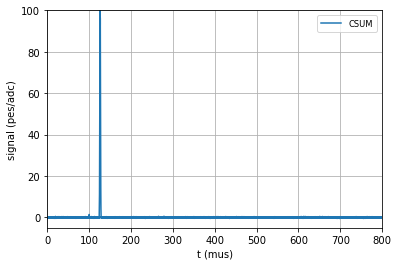

In [84]:
mpl.plot_calibrated_sum_in_mus(csum,
                               tmin=0, tmax=800,
                               signal_min=-5, signal_max=100,
                               csum=True, csum_mau=False)

**Run over one event**

In [ ]:
event = 0
BLR = pmtblr[event]
RWF = pmtrwf[event]

## The full pre-proc 

In [ ]:
s1par = S12P(tmin=90*units.mus, tmax=110*units.mus, lmin=4, lmax=20, stride=4, rebin=False)
s2par = S12P(tmin=110*units.mus, tmax=1190*units.mus, lmin=80, lmax=200000, stride=40, rebin=True)
thresholds = ThresholdParams(thr_s1=0.2*units.pes, 
                     thr_s2=1*units.pes, 
                     thr_MAU=3*units.adc, 
                     thr_sipm=5*units.pes, 
                     thr_SIPM=20*units.pes )

In [ ]:
CSUM, P = pf.compute_csum_and_pmaps(pmtrwf, sipmrwf, s1par, s2par, thresholds, event)

In [ ]:
CSUM

In [ ]:
P

In [ ]:
P.S2

In [ ]:
P.S2Si

In [ ]:
for nsipm in P.S2Si[0]:
    assert len(P.S2Si[0][nsipm]) == len(P.S2[0][0])

In [ ]:
pmf.scan_s12(P.S1)

In [ ]:
pmf.scan_s12(P.S2)

In [ ]:
P.S2Si

#### Plot SiPMs

In [ ]:
pmf.plot_s2si_map(P.S2Si)

In [ ]:
pmf.scan_s2si_map(P.S2Si)

### Write to disk

In [ ]:
with pmap_writer(PMAP_file) as write:
    for event in range(10):
        timestamp = int(time.time())
        CSUM, P = compute_pmp(pmtrwf, s1par, s2par, thr, event)
        S1 = S12(P.S1)
        S2 = S12(P.S2)
        Si = S2Si(P.S2Si)
        write(0, event, timestamp, S1, S2, Si)

### Read back

In [ ]:
s1df, s2df, s2sidf = read_pmaps(PMAP_file)
rundf, evtdf = read_run_and_event_from_pmaps_file(PMAP_file)

In [ ]:
rundf

In [ ]:
evtdf

In [ ]:
evts_out = evtdf.evt_number.values

In [ ]:
evts_out

In [ ]:
S1L = df_to_pmaps_dict(s1df)
S2L = df_to_pmaps_dict(s2df)
S2SiL = df_to_s2si_dict(s2sidf)

In [ ]:
S1L

In [ ]:
S2L

In [ ]:
S2SiL

### Check data

In [ ]:
for event in range(10):
    CSUM, P = compute_pmp(pmtrwf, s1par, s2par, thr, event)
   
    if P.S1:
        s1p = S1L[event]
        for peak_number in s1p:
            np.testing.assert_allclose(s1p[peak_number].t, P.S1[peak_number][0])
            np.testing.assert_allclose(s1p[peak_number].E, P.S1[peak_number][1])
   
    if P.S2:
        s1p = S2L[event]
        for peak_number in s1p:
            np.testing.assert_allclose(s1p[peak_number].t, P.S2[peak_number][0])
            np.testing.assert_allclose(s1p[peak_number].E, P.S2[peak_number][1])

    if P.S2Si:
        s1p = S2SiL[event]
        for peak_number in s1p:
            sipm = s1p[peak_number]
            sipm2 = P.S2Si[peak_number]
            for nsipm in sipm:
                np.testing.assert_allclose(sipm[nsipm], sipm2[nsipm])



### Test running of IRENE

In [ ]:
PATH_IN = os.path.join(os.environ['ICDIR'],
              'database/test_data/',
              'run_2983.h5')
PATH_OUT = os.path.join(os.environ['IC_DATA'],
              'run_2983_pmaps.h5')
#PATH_IN = os.path.join(os.environ['IC_DATA'],'LSC/2980/run_2980.gdc1next.000.next1el_2980.root.h5')
#PATH_OUT = os.path.join(os.environ['IC_DATA'],'run_2980_pmaps.h5')
conf_file = os.path.join(os.environ['IC_CONFIG'],'irene_Kr2983.conf')
nrequired, nactual, _ = IRENE(['IRENE',
                                   '-c', conf_file,
                                   '-i', PATH_IN,
                                   '-o', PATH_OUT,
                                   '-n', '5',
                                   '-r', '2983'])
if nrequired > 0:
    assert nrequired == nactual


In [ ]:
h5in = tb.open_file(PATH_IN,  mode='r')

In [ ]:
h5in.root.Run.runInfo[:][0][0]

In [ ]:
h5in.root.Run.events[:]

In [ ]:
rundf, evtdf = read_run_and_event_from_pmaps_file(PATH_OUT)

In [ ]:
evts_out = evtdf.evt_number.values

In [ ]:
evts_out

In [ ]:
tsout_out = evtdf.timestamp.values

In [ ]:
tsout_out

In [ ]:
rundf.run_number[0]

In [ ]:
evt_in = h5in.root.Run.events[:]
evts_in = []
ts_in = []
for e in evt_in:
    evts_in.append(e[0])
    ts_in.append(e[1])
print(evts_in)
print(ts_in)

In [ ]:
np.testing.assert_array_equal(evts_in, evts_out)

In [ ]:
evt_in

In [ ]:
evts_in = []
for e in evt_in:
    evts_in.append(e[0])
print(evts_in)

In [ ]:
h5in.close()

End of notebook